In [2]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
# set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

In [4]:
# check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Create the cartpole environment using the new Gymansium API
env = gym.make('CartPole-v1', render_mode = None)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"State size: {state_size}, Action size: {action_size}")

State size: 4, Action size: 2


In [6]:
# Define the neural Network architectue for DQN

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, fc1_units = 64, fc2_units = 64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
# Define the experience replay buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names = ["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)


    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [8]:
# Define prioritized experience replay buffer
class PrioritizedReplayBuffer:
    def __init__(self, buffer_size, batch_size, alpha=0.6):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.alpha = alpha  # prioritization exponent
        self.priorities = np.zeros((buffer_size,), dtype=np.float32)
        self.pos = 0
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)

        max_priority = np.max(self.priorities) if self.memory else 1.0

        if len(self.memory) < self.priorities.shape[0]:
            self.memory.append(e)
        else:
            self.memory[self.pos] = e

        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.priorities.shape[0]

    def sample(self, beta=0.4):
        if len(self.memory) < self.batch_size:
            return None

        # Calculate sampling probabilities
        priorities = self.priorities[:len(self.memory)]
        probabilities = priorities ** self.alpha
        probabilities /= np.sum(probabilities)

        # Sample indices according to the priority distribution
        indices = np.random.choice(len(self.memory), self.batch_size, replace=False, p=probabilities)

        # Calculate importance sampling weights
        weights = (len(self.memory) * probabilities[indices]) ** (-beta)
        weights /= np.max(weights)  # Normalize weights
        weights = torch.from_numpy(weights).float().to(device)

        experiences = [self.memory[idx] for idx in indices]

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones, indices, weights)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)

In [9]:
# Basic DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, buffer_size=100000, batch_size=64, gamma=0.99,
                 tau=1e-3, lr=5e-4, update_every=4):
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every
        self.lr = lr

        # Initialize Q-networks (online and target)
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Initialize replay memory
        self.memory = ReplayBuffer(buffer_size, batch_size)

        # Initialize time step for update
        self.t_step = 0

        self.losses = []

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every update_every time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get a batch and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                loss = self.learn(experiences)
                self.losses.append(loss)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Compute Q targets for current states
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

        return loss.item()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters: θ_target = τ*θ_local + (1 - τ)*θ_target"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [10]:
# Double DQN Agent(use dqn with double q-learning)
class DoubleDQNAgent(DQNAgent):
    def __init__(self, state_size, action_size, buffer_size=100000, batch_size=64, gamma=0.99,
                 tau=1e-3, lr=5e-4, update_every=4):
        super(DoubleDQNAgent, self).__init__(state_size, action_size, buffer_size, batch_size, gamma,
                                          tau, lr, update_every)
        

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Double DQN: use local network to select best action and target network to evaluate it
        next_actions = self.qnetwork_local(next_states).detach().argmax(1).unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).gather(1, next_actions)

        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

        return loss.item()


In [11]:

# Prioritized Experience Replay Double DQN Agent
class PERDoubleDQNAgent(DoubleDQNAgent):
    def __init__(self, state_size, action_size, buffer_size=100000, batch_size=64, gamma=0.99,
                 tau=1e-3, lr=5e-4, update_every=4, alpha=0.6, beta_start=0.4, beta_frames=100000):
        super(PERDoubleDQNAgent, self).__init__(state_size, action_size, buffer_size, batch_size, gamma,
                                             tau, lr, update_every)

        # Replace standard replay buffer with prioritized version
        self.memory = PrioritizedReplayBuffer(buffer_size, batch_size, alpha)

        # Beta parameter for importance sampling
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame_idx = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Update beta parameter
        self.frame_idx += 1

        # Learn every update_every time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get a batch and learn
            if len(self.memory) > self.batch_size:
                # Calculate beta based on training progress
                beta = min(1.0, self.beta_start + self.frame_idx * (1.0 - self.beta_start) / self.beta_frames)
                experiences = self.memory.sample(beta)

                if experiences is not None:
                    loss = self.learn(experiences)
                    self.losses.append(loss)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones, indices, weights = experiences

        # Double DQN: use local network to select best action and target network to evaluate it
        next_actions = self.qnetwork_local(next_states).detach().argmax(1).unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).gather(1, next_actions)

        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Calculate TD error
        td_error = (Q_targets - Q_expected).abs().detach().cpu().numpy()

        # Update priorities in the replay buffer
        new_priorities = td_error + 1e-6  # small constant to avoid zero priority
        self.memory.update_priorities(indices, new_priorities)

        # Apply importance sampling weights to the loss
        loss = (weights * F.mse_loss(Q_expected, Q_targets, reduction='none')).mean()

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

        return loss.item()

In [12]:
# Function to train an agent
def train_agent(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start

    for i_episode in tqdm(range(1, n_episodes+1)):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)  # decrease epsilon

        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')

    return scores

In [13]:
def plot_scores(scores, title):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(title)

    # plot rolling average
    window_size = 100
    scores_mean = [np.mean(scores[max(0, i-window_size):i+1]) for i in range(len(scores))]
    plt.plot(np.arange(len(scores_mean)), scores_mean, 'r', label=f'Rolling Mean (window={window_size})')

    plt.legend()
    plt.grid()
    return fig

def plot_losses(agent, title):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(agent.losses)), agent.losses)
    plt.ylabel('Loss')
    plt.xlabel('Step #')
    plt.title(title)
    plt.grid()
    return fig



In [14]:
# function to evaluate agent performance
def evaluate_agent(agent, n_episodes=10, render= False):
    eval_env = gym.make('CartPole-v1')
    scores = []

    for i in range(n_episodes):
        state, _ = eval_env.reset()
        score = 0
        done = False
        while not done:
            action = agent.act(state, eps=0)  # Greedy action selection for evaluation
            next_state, reward, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            state = next_state
            score += reward
        scores.append(score)

    eval_env.close()
    print(f'Evaluation over {n_episodes} episodes: Mean: {np.mean(scores):.2f}, Min: {np.min(scores):.2f}, Max: {np.max(scores):.2f}')
    return scores


In [15]:
n_episodes = 2500

# Hyperparameters for all agents
buffer_size = 100000
batch_size = 256
gamma = 0.95
tau = 1e-3
lr = 5e-4
update_every = 4
max_t = 1000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995



In [16]:
# Create agents
dqn_agent = DQNAgent(state_size, action_size, buffer_size, batch_size, gamma, tau, lr, update_every)
double_dqn_agent = DoubleDQNAgent(state_size, action_size, buffer_size, batch_size, gamma, tau, lr, update_every)
# per_double_dqn_agent = PERDoubleDQNAgent(state_size, action_size, buffer_size, batch_size, gamma, tau, lr, update_every)

In [ ]:

# Train the DQN agent
print("Training DQN Agent...")
dqn_scores = train_agent(dqn_agent, n_episodes, max_t, eps_start, eps_end, eps_decay)


Training DQN Agent...


  0%|          | 0/2500 [00:00<?, ?it/s]

In [17]:

# Train the Double DQN agent
print("\nTraining Double DQN Agent...")
double_dqn_scores = train_agent(double_dqn_agent, n_episodes, max_t, eps_start, eps_end, eps_decay)



Training Double DQN Agent...


  0%|          | 0/2500 [00:00<?, ?it/s]

Episode 100	Average Score: 18.15
Episode 200	Average Score: 14.18
Episode 300	Average Score: 11.50
Episode 400	Average Score: 10.39
Episode 500	Average Score: 10.03
Episode 600	Average Score: 9.38
Episode 700	Average Score: 9.60
Episode 800	Average Score: 9.87
Episode 900	Average Score: 11.20
Episode 1000	Average Score: 13.38
Episode 1100	Average Score: 80.00
Episode 1200	Average Score: 152.81
Episode 1300	Average Score: 255.06
Episode 1400	Average Score: 263.74
Episode 1500	Average Score: 209.74
Episode 1600	Average Score: 260.55
Episode 1700	Average Score: 220.80
Episode 1800	Average Score: 243.75
Episode 1900	Average Score: 245.84
Episode 2000	Average Score: 228.15
Episode 2100	Average Score: 189.66
Episode 2200	Average Score: 183.52
Episode 2300	Average Score: 182.59
Episode 2400	Average Score: 177.15
Episode 2500	Average Score: 183.19


In [18]:

# # Train the Prioritized Experience Replay Double DQN agent
# print("\nTraining Prioritized Experience Replay Double DQN Agent...")
# per_double_dqn_scores = train_agent(per_double_dqn_agent, n_episodes, max_t, eps_start, eps_end, eps_decay)


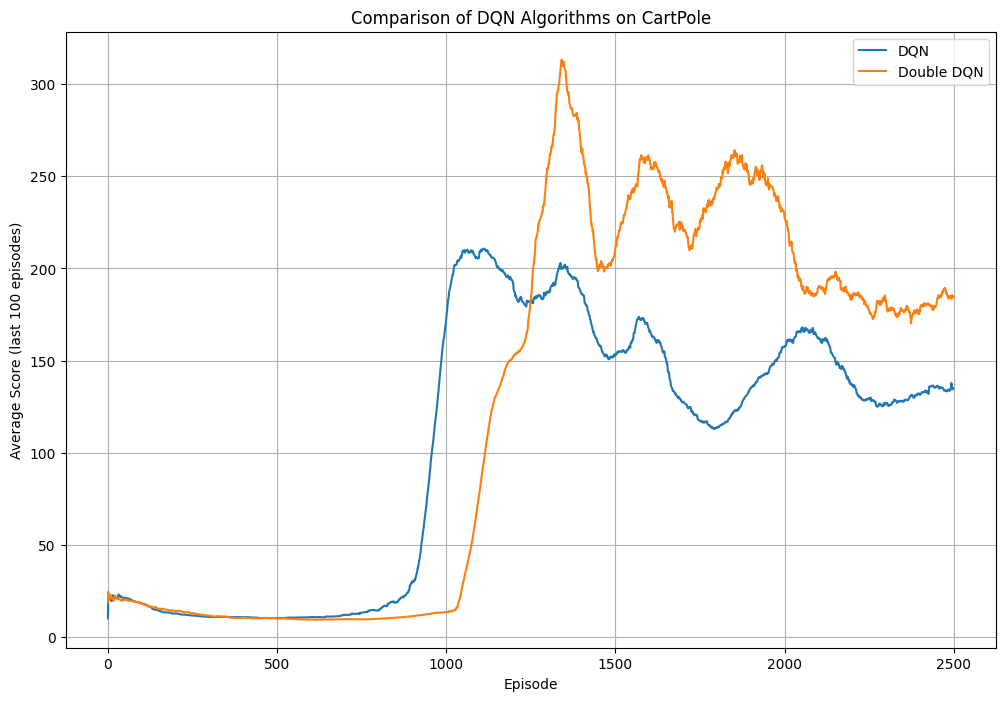

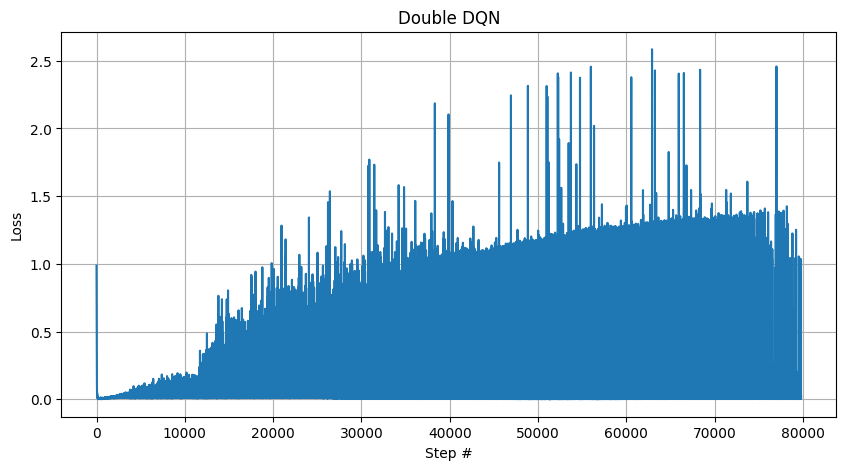

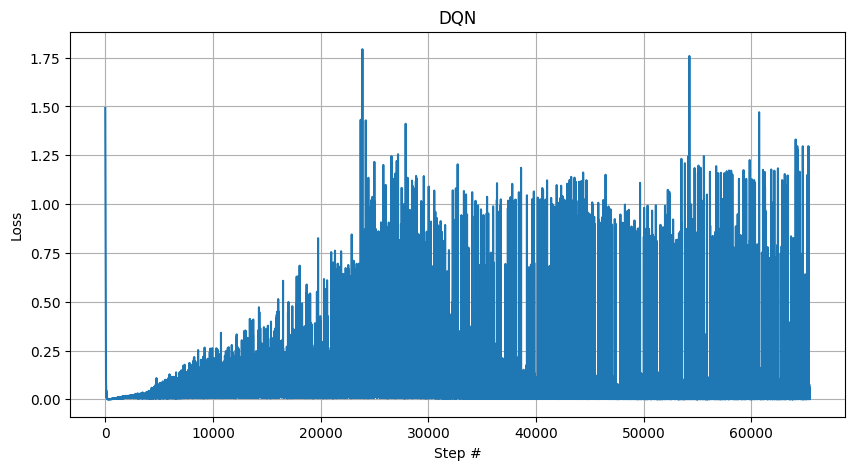

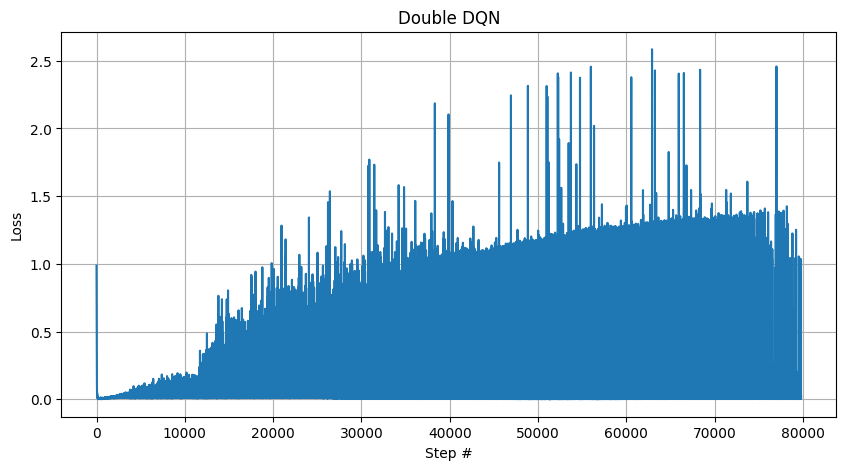

In [19]:

# Plot the learning curves
plt.figure(figsize=(12, 8))

# Calculate rolling averages
window_size = 100
dqn_avg = [np.mean(dqn_scores[max(0, i-window_size):i+1]) for i in range(len(dqn_scores))]
double_dqn_avg = [np.mean(double_dqn_scores[max(0, i-window_size):i+1]) for i in range(len(double_dqn_scores))]
# per_double_dqn_avg = [np.mean(per_double_dqn_scores[max(0, i-window_size):i+1]) for i in range(len(per_double_dqn_scores))]

plt.plot(dqn_avg, label='DQN')
plt.plot(double_dqn_avg, label='Double DQN')
# plt.plot(per_double_dqn_avg, label='PER Double DQN')

plt.xlabel('Episode')
plt.ylabel('Average Score (last 100 episodes)')
plt.title('Comparison of DQN Algorithms on CartPole')
plt.legend()
plt.grid()
plt.show()

# Plot the training losses
plot_losses(dqn_agent, "DQN")
plot_losses(double_dqn_agent, "Double DQN")
# plot_losses(per_double_dqn_agent, "PER Double DQN")


In [1]:

# Create a DataFrame for statistical analysis
results = {
    'DQN': dqn_scores,
    'Double DQN': double_dqn_scores
}

# For each algorithm, calculate various statistics
stats = {}
for name, scores in results.items():
    stats[name] = {
        'Mean Score': np.mean(scores),
        'Max Score': np.max(scores),
        'Last 100 Mean': np.mean(scores[-100:]),
        'Episodes to Solve (>200)': next((i for i, avg in enumerate([np.mean(scores[max(0, i-100):i+1]) for i in range(len(scores))]) if avg >= 200), len(scores))
    }

stats_df = pd.DataFrame(stats).T
print("\nPerformance Statistics:")
print(stats_df)

# Evaluate the trained agents
print("\nEvaluating DQN Agent:")
dqn_eval = evaluate_agent(dqn_agent, n_episodes=10)

print("\nEvaluating Double DQN Agent:")
double_dqn_eval = evaluate_agent(double_dqn_agent, n_episodes=10)

# print("\nEvaluating PER Double DQN Agent:")
# per_double_dqn_eval = evaluate_agent(per_double_dqn_agent, n_episodes=10)

# Plot evaluation results
labels = ['DQN', 'Double DQN']
eval_means = [np.mean(dqn_eval), np.mean(double_dqn_eval)]
eval_stds = [np.std(dqn_eval), np.std(double_dqn_eval)]

plt.figure(figsize=(10, 6))
plt.bar(labels, eval_means, yerr=eval_stds, alpha=0.7, capsize=10)
plt.ylabel('Mean Score')
plt.title('Evaluation Performance Comparison')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


NameError: name 'dqn_scores' is not defined